### Import Statements

In [72]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, k_means
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#### Contents:
- [Yelp Data](#Yelp-Data)
- [Zillow Data](#Zillow-Data)
- [Combined Data](#Combined-Data)
- [Basic Features](#Basic-Features)
- [Advanced Features](#Advanced-Features)

### Yelp Data

In [73]:
# Importing yelp data
df = pd.read_json('Data/yelp_academic_dataset_business.json', lines = True)
df.head(3)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,1314 44 Avenue NE,"{'BikeParking': 'False', 'BusinessAcceptsCredi...",Apn5Q_b6Nz61Tq4XzPdf9A,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",Calgary,"{'Monday': '8:30-17:0', 'Tuesday': '11:0-21:0'...",1,51.091813,-114.031675,Minhas Micro Brewery,,T2E 6L6,24,4.0,AB
1,,"{'Alcohol': 'none', 'BikeParking': 'False', 'B...",AjEbIBw6ZFfln7ePHha9PA,"Chicken Wings, Burgers, Caterers, Street Vendo...",Henderson,"{'Friday': '17:0-23:0', 'Saturday': '17:0-23:0...",0,35.960734,-114.939821,CK'S BBQ & Catering,,89002,3,4.5,NV
2,1335 rue Beaubien E,"{'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...",O8S5hYJ1SMc8fA4QBtVujA,"Breakfast & Brunch, Restaurants, French, Sandw...",Montréal,"{'Monday': '10:0-22:0', 'Tuesday': '10:0-22:0'...",0,45.540503,-73.599300,La Bastringue,Rosemont-La Petite-Patrie,H2G 1K7,5,4.0,QC


In [74]:
# checking shape
df.shape

(188593, 15)

In [75]:
#Identifying the available data by state with unique zip codes
df.groupby('state').count()['postal_code'].sort_values(ascending = False).head(20)

state
AZ     56495
NV     35688
ON     32393
NC     14359
OH     13664
PA     10966
QC      8756
AB      7670
WI      5042
IL      1937
SC       770
NYK      163
NI       134
IN       101
OR        72
BY        60
ST        45
CO        43
C         34
HE        32
Name: postal_code, dtype: int64

In [76]:
# Limit the data to US and to states with most zip codes
df = df[(df['state'] == 'AZ')|(df['state']== 'NV')|(df['state']=='NC')|(df['state'] =="OH")|(df['state']=='PA')|(df['state']=='WI')]#|(df['state']=='SC')|(df['state']=='IL')]


In [77]:
df.shape

(136214, 15)

In [78]:
# checking number of missing values
df.isnull().sum()

address             0
attributes      19064
business_id         0
categories        410
city                0
hours           30097
is_open             0
latitude            4
longitude           4
name                0
neighborhood        0
postal_code         0
review_count        0
stars               0
state               0
dtype: int64

In [79]:
# dropping unnecessary columns
df = df.drop(['address', 'city'], axis=1)

# dropping columns that are suspected of being poor predictors and have many missing values 
df = df.drop(['attributes', 'hours', 'neighborhood'], axis=1)

In [80]:
df['categories'].head()

1    Chicken Wings, Burgers, Caterers, Street Vendo...
3                        Insurance, Financial Services
5                                   Coffee & Tea, Food
8                                 Mexican, Restaurants
9                Flowers & Gifts, Gift Shops, Shopping
Name: categories, dtype: object

In [81]:
# Create features based on number of restaurant categories for each business

# instantiating count vectorizer
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None) 

# applying count vectorizer to yelp categories column
df['categories'] = df['categories'].fillna('missing')
cat_vector = vectorizer.fit_transform(df['categories']).toarray()

# merging results with original yelp data frame
cat_vector_df = pd.DataFrame(cat_vector, columns = vectorizer.get_feature_names())
df = pd.merge(left = df, right = cat_vector_df, on=df.index).drop('key_0', axis=1)

In [82]:
# Checking for nulls
df.isnull().sum()[df.isnull().sum()>0]

latitude     4
longitude    4
dtype: int64

In [83]:
df = df.dropna()

In [84]:
# checking first three rows after count vectorizer operation
df.head(3)

,business_id,categories,is_open,latitude,longitude,name,postal_code,review_count,stars,state,...,women,workers,wraps,yelp,yoga,yogurt,your,yourself,ziplining,zoos
0,AjEbIBw6ZFfln7ePHha9PA,"Chicken Wings, Burgers, Caterers, Street Vendo...",0,35.960734,-114.939821,CK'S BBQ & Catering,89002,3,4.5,NV,...,0,0,0,0,0,0,0,0,0,0
1,bFzdJJ3wp3PZssNEsyU23g,"Insurance, Financial Services",1,33.449999,-112.076979,Geico Insurance,85003,8,1.5,AZ,...,0,0,0,0,0,0,0,0,0,0
2,45bWSZtniwPRiqlivpS8Og,"Coffee & Tea, Food",1,33.671375,-112.030017,The Coffee Bean & Tea Leaf,85024,63,4.0,AZ,...,0,0,0,0,0,0,0,0,0,0


In [85]:
# drop unnecessary columns
df = df.drop(['business_id', 'categories'], axis=1)


In [86]:
#### Combining the data

In [87]:
# Setting up a dummy feature for total count of businesses
# Aggregating the dataframe based on zip codes and summing up all the values

df['total'] = 1
yelp_df = df.groupby('postal_code').sum()
yelp_df.head()

,is_open,latitude,longitude,review_count,stars,3d,abatement,acai,accessories,accountants,...,workers,wraps,yelp,yoga,yogurt,your,yourself,ziplining,zoos,total
postal_code,,,,,,,,,,,,,,,,,,,,,
,371,14514.917699,-43502.208616,4273,1474.5,0,0,0,0,0,...,0,1,2,0,2,0,0,0,0,410
06280,1,36.166228,-115.192580,3,5.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
08054,1,39.980331,-74.858983,5,4.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10300,1,36.160569,-115.320885,3,2.5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
15003,37,1623.793452,-3209.068869,456,158.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,40


In [88]:
# Adding postal_code to the features and resetting the index
yelp_df['postal_code'] = yelp_df.index
yelp_df = yelp_df.reset_index(drop = True)

In [89]:
# Dropping the null zip code and transforming the postal_code to an int
yelp_df = yelp_df.drop(0)
yelp_df['postal_code'] = yelp_df['postal_code'].astype(int)
yelp_df[['postal_code']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 825 entries, 1 to 825
Data columns (total 1 columns):
postal_code    825 non-null int64
dtypes: int64(1)
memory usage: 12.9 KB


### Zillow Data

In [90]:
# importing zillow data
zillow_df_sqft = pd.read_csv('Data/Zip_MedianValuePerSqft_AllHomes.csv', encoding='windows-1252')
zillow_df_national = pd.read_csv('Data/Zip_Zhvi_Summary_AllHomes.csv', encoding='windows-1252')

In [91]:
zillow_df_sqft.head(3)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11
0,61639,10025,New York,NY,New York-Newark-Jersey City,New York County,1,199.0,199.0,200.0,...,1331,1332,1338,1346,1346,1340,1334,1329,1320,1312
1,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,2,155.0,156.0,156.0,...,474,477,477,477,477,477,477,478,478,479
2,61637,10023,New York,NY,New York-Newark-Jersey City,New York County,3,353.0,355.0,356.0,...,1646,1638,1645,1655,1650,1632,1615,1602,1588,1579


In [92]:
zillow_df_national.head(3)

,Date,RegionID,RegionName,State,Metro,County,City,SizeRank,Zhvi,MoM,QoQ,YoY,5Year,10Year,PeakMonth,PeakQuarter,PeakZHVI,PctFallFromPeak,LastTimeAtCurrZHVI
0,2018-11-30,61639,10025,NY,New York-Newark-Jersey City,New York County,New York,0,1064000,-0.007648,-0.021069,-0.063380,NaN,NaN,2017-12,2017-Q4,1138900,-0.065765,2017-03
1,2018-11-30,84654,60657,IL,Chicago-Naperville-Elgin,Cook County,Chicago,1,354000,0.007112,0.016657,0.019292,NaN,NaN,2018-11,2018-Q4,354000,0.000000,2018-11
2,2018-11-30,61637,10023,NY,New York-Newark-Jersey City,New York County,New York,2,1380100,-0.007051,-0.040798,-0.131958,NaN,NaN,2016-12,2016-Q4,1619900,-0.148034,2013-11


In [93]:
# Selecting needed columns from both datasets
zillow_df_sqft = zillow_df_sqft[['RegionName','2018-07','State']]
zillow_df_national = zillow_df_national[['RegionName','Zhvi']]

In [94]:
# lowercasing column names
zillow_df_sqft.columns = map(str.lower, zillow_df_sqft.columns)
zillow_df_national.columns = map(str.lower, zillow_df_national.columns)
# renaming target column
zillow_df_sqft.rename({'2018-07': 'price_per_sqft'}, axis=1, inplace=True)
zillow_df_national.rename({'zhvi': 'price'}, axis=1, inplace=True)

In [95]:
# Merging the two datasets
zillow_df = pd.merge(left=zillow_df_sqft, right=zillow_df_national, left_on='regionname', right_on='regionname')

In [96]:
zillow_df.head(3)

,regionname,price_per_sqft,state,price
0,10025,1340,NY,1064000
1,60657,477,IL,354000
2,10023,1632,NY,1380100


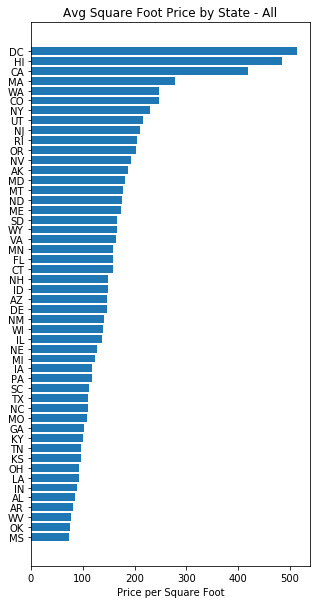

In [97]:
# Explore the price_per_sqft by state
plt.figure(figsize=(5,10))
plt.barh(zillow_df.groupby('state').mean()['price_per_sqft'].sort_values().index, zillow_df.groupby('state').mean()['price_per_sqft'].sort_values())
plt.title('Avg Square Foot Price by State - All')
plt.xlabel('Price per Square Foot')
plt.savefig('Images/Avg Square Foot Price by State - All')


In [98]:
# Get statistical distribution of the data
zillow_df.groupby('state').mean()['price_per_sqft'].describe()

count     50.000000
mean     166.205246
std       92.799310
min       72.481752
25%      108.959880
50%      147.674705
75%      185.541217
max      512.809524
Name: price_per_sqft, dtype: float64

### Combined Data

In [99]:
# merging yelp and zillow data together

combined_df = pd.merge(yelp_df, zillow_df, left_on='postal_code', right_on='regionname').drop(['regionname'], axis=1)
combined_df.shape

(489, 1366)

In [100]:
combined_df[combined_df['total']>=10].shape

(378, 1366)

In [101]:
# Filtering zip codes to ensure we are collecting at least 10 businesses in each, this number was chosed 
# rather arbitrary and more analysis could be done for the sweetspot, but I want to ensure we have 
# sufficient data
final_df = combined_df[combined_df['total']>=10]

### Basic Features

In [102]:
# Creating mean stars, mean_review_count, and percent_open features

final_df['stars_mean'] = final_df['stars']/final_df['total']
final_df['mean_review_count'] = final_df['review_count']/final_df['total']
final_df['percent_is_open'] = final_df['is_open']/final_df['total']

/Users/dmitriy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/dmitriy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/dmitriy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [103]:
final_df.head(3)

,is_open,latitude,longitude,review_count,stars,3d,abatement,acai,accessories,accountants,...,ziplining,zoos,total,postal_code,price_per_sqft,state,price,stars_mean,mean_review_count,percent_is_open
2,37,1623.793452,-3209.068869,456,158.0,0,0,0,0,0,...,0,0,40,15003,65,PA,78800,3.950000,11.400000,0.925000
6,158,7265.418314,-14419.537822,3056,622.5,0,0,0,1,0,...,0,0,180,15017,125,PA,172200,3.458333,16.977778,0.877778
7,23,1094.787345,-2155.131919,160,96.0,0,0,0,0,0,...,0,0,27,15024,114,PA,152700,3.555556,5.925926,0.851852


### Advanced-Features

In [104]:
# cleaning up postal_code
df = df[df['postal_code']!='']
df['postal_code'] = df['postal_code'].astype(int)

In [105]:
# Get Inertia Scores based on latitude and longatude of the data
from sklearn.cluster import KMeans

km_inertia = pd.DataFrame(columns=['inertia_scores'], index=final_df['postal_code'])
km = KMeans(n_clusters=1, random_state=42)
for postal_code in final_df['postal_code']:
    temp_df = df[df['postal_code'] == postal_code][['latitude','longitude']].copy()
    km.fit(temp_df)
    km_inertia.loc[postal_code, 'inertia_scores'] = km.inertia_

km_inertia.reset_index()
final_df = final_df.merge(km_inertia, on='postal_code')

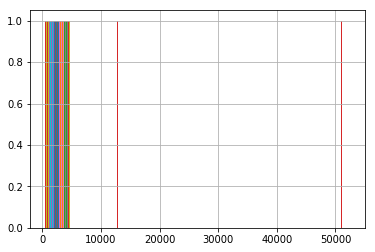

In [106]:
final_df['inertia_scores'].hist()

In [107]:
# Remove outliers from our data very likely due to to errors in the data
final_df = final_df[final_df['inertia_scores'] <= 10]

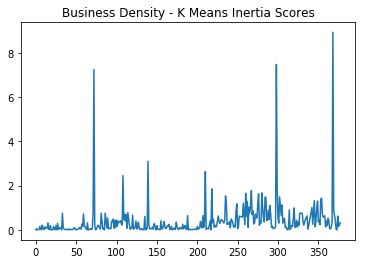

In [113]:
final_df['inertia_scores'].plot()
plt.title('Business Density - K Means Inertia Scores')
plt.savefig('Images/Business Density - K-means Inertia Scores');

In [109]:
final_df.shape

(351, 1370)

In [110]:
#dropping unnecessary columns
final_df = final_df.drop(columns = ['latitude', 'longitude','postal_code'])

In [111]:
final_df.to_csv('Data/cleaned_data.csv', index = False)